## Final Project Submission

Please fill out:
* Student name: Aaron Lee
* Student pace: self paced
* Scheduled project review date/time: ???
* Instructor name: Jeff Herman
* Blog post URL: ??????


#  Questions for this project
- What is the price of a hypothetical home, given attributes. Use a predictive model.
- How does location affect the home price in King County.  Use folium.
- How much should you spend on a renovation and still expect a return on investment.

In [796]:
# Import libraries used in this project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium
import folium.plugins
import branca
import branca.colormap as cm
from shapely.geometry import Polygon, Point, MultiPolygon, shape, GeometryCollection

import json

import pickle

import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

%matplotlib inline

## Import the data from our EDA

In [797]:
# Unpickle the data from the first section
kc2 = pd.read_pickle('01_eda_out.pkl')
kc2.describe()
kc2.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month', 'longlat',
       'points', 'school_district', 'school_score', 'nearest_water',
       'downtown_dist', 'nearest_bucks'],
      dtype='object')

## Choose the columns I want to use to answer my questions.
## let's leave out the following:
- floors, not of interest.  The floors is a function of home style, era, and area mostly. Should be teased out in other categories
- view, unlikely to be consequential to the price
- grade, has values from 3 to 13 with missing values.  Will use 'condition' col instead which is a simple 1 to 5.
- sqft_above, sqft_basement.  We will use the sqft_living as the size of the home and ignore others
- yr_built.  We will use renovated year instead since we addressed no renovation issue to include year built
- date.  All dates are with a year range.  We could investigate month or week though to see how it affects price
- waterfront.  We now have nearest_water
- nearest 15 data.  We will use sqft data only.  I feel like this could affect the model if we include too many sqft.  Can alter later maybe.

## We will keep:
- price will be our feature of interest
- bedrooms (>1 to 5)
- bathrooms (>1 to 6)
- sqft_living (size of home)
- condition (1 to 5)
- nearest_water (incorporates waterfront data also)
- zipcode 
- yr_renovated (inclueds yr_built data)
- school_district (may use it instead of zip if the data looks good)
- lat, long, but will change it to map Point objects


In [798]:
# Our model will predict family homes, so we will tailor our dataset to match typcial family homes
# We currently have homes over 7 million dollars which are outliers

## Get rid of any odd data or extreme outliers that we might be using
sorted(kc2['yr_built'].unique())  # looks good, no change here


# Price 
kc2 = kc2.loc[(kc2['price'] > 120000) & (kc2['price'] < 2000000)]
# We lose ~2000 (5% of data) but drastically improve the modeling
# most losses are on the high end of price range

# Bedrooms
sorted(kc2['bedrooms'].unique())  
# We have a place with 33 rooms!!  (typo?). Let's drop it
# Also looking at other many bedroomed places, there are a few inconsistencies, 
# eg.  9 bedroom 2 bath and 8 bedroom with 2200 sqft.
# I decided to drop anything more than 5 beds.  Narrows it to more typical family homes. 
kc2 = kc2.loc[(kc2['bedrooms'] >= 2) & (kc2['bedrooms'] <= 5)]  
# We lose another ~1000


# Bathrooms
sorted(kc2['bathrooms'].unique())
# Family home would expect 1.5 at least
kc2 = kc2.loc[(kc2['bathrooms'] >= 1.5) & (kc2['bathrooms'] <= 5)]  
# Lose another ~1000

# Condition
sorted(kc2['condition'].unique())  # Looks good
# Get rid of poor condition homes
kc2 = kc2.loc[kc2['condition'] >= 3]
print(len(kc2))

# Zipcode
sorted(kc2['zipcode'].unique())  # looks good

# sqft_living
#sorted(kc['sqft_living'].unique())[:100]  # looks at small and large homes
# will chop off the tails.  Under 1500 and over 5500.  These are probably more suitable to our model and reflect
# typical homes we are interested in.
kc2 = kc2.loc[(kc2['sqft_living'] > 1000) & (kc2['sqft_living'] < 4000)]
# lose another ~1500
print(len(kc2))



# Had trouble with school score of zero
kc2['school_score'] = kc2['school_score'].apply(lambda x: x + 1)
kc2 = kc2.dropna()

kc2['quarter'] = kc2['month'] // 4 + 1


kc2.isna().sum()


16680
15989


id                 0
date               0
price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
grade              0
sqft_above         0
sqft_basement      0
yr_built           0
yr_renovated       0
zipcode            0
lat                0
long               0
sqft_living15      0
sqft_lot15         0
month              0
longlat            0
points             0
school_district    0
school_score       0
nearest_water      0
downtown_dist      0
nearest_bucks      0
quarter            0
dtype: int64

## Single variable regression analysis

We will start by looking to see if any of our chosen

BEDROOMS BEDROOMS BEDROOMS BEDROOMS BEDROOMS 
Housing Data - Regression Analysis and Diagnostics for Price~bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     701.4
Date:                Thu, 16 Jul 2020   Prob (F-statistic):          2.65e-151
Time:                        19:18:37   Log-Likelihood:            -2.2174e+05
No. Observations:               15984   AIC:                         4.435e+05
Df Residuals:                   15982   BIC:                         4.435e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

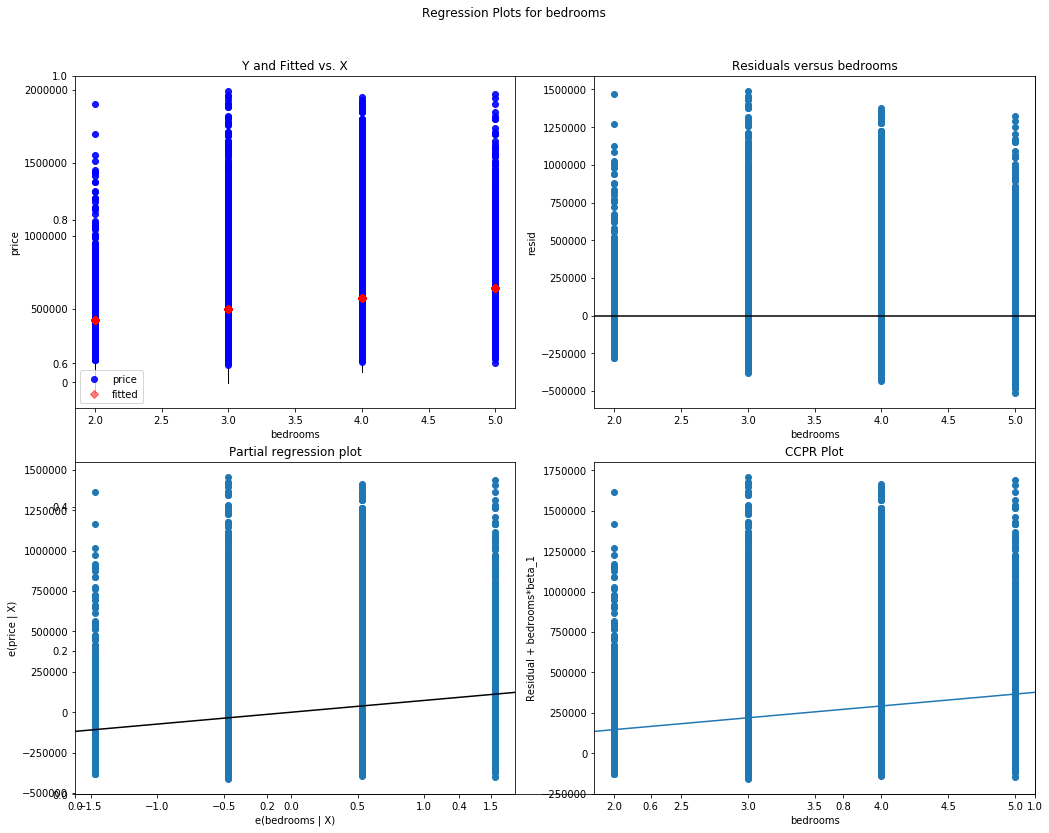

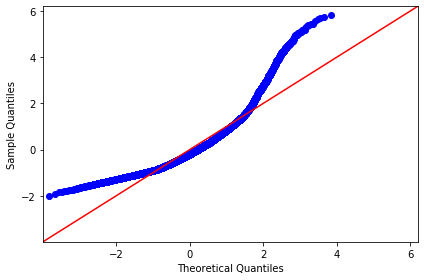

BATHROOMS BATHROOMS BATHROOMS BATHROOMS BATHROOMS 
Housing Data - Regression Analysis and Diagnostics for Price~bathrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     2561.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:18:40   Log-Likelihood:            -2.2090e+05
No. Observations:               15984   AIC:                         4.418e+05
Df Residuals:                   15982   BIC:                         4.418e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

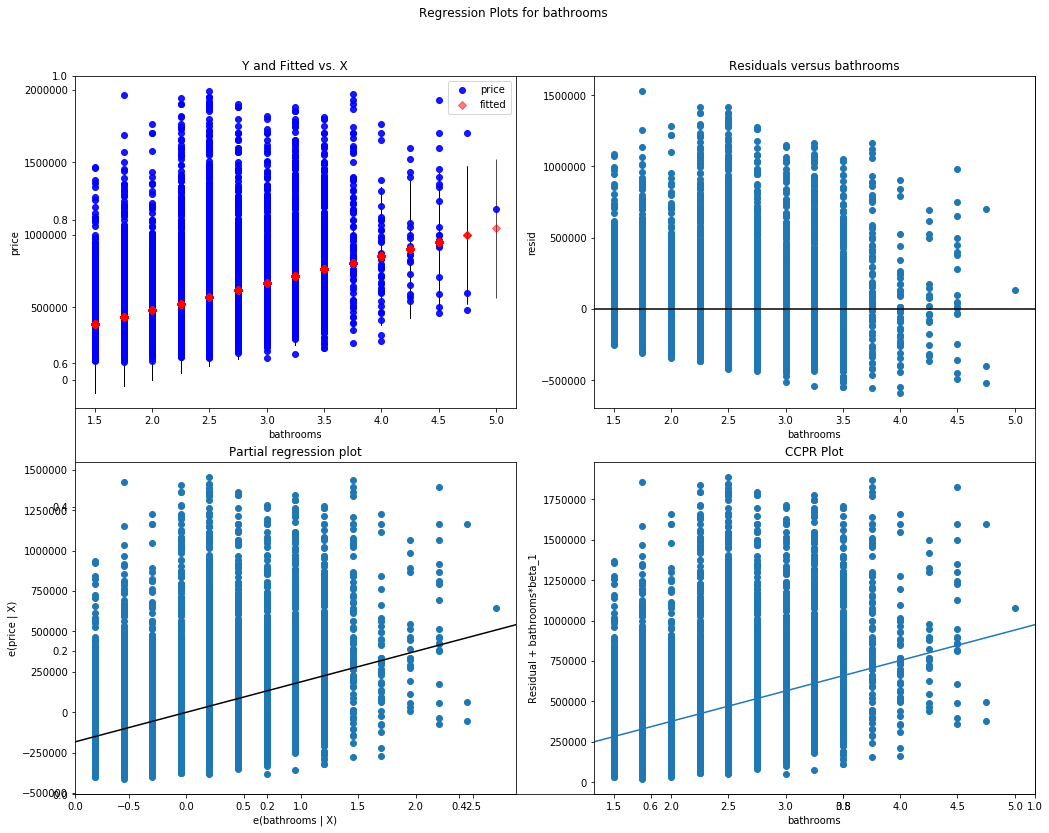

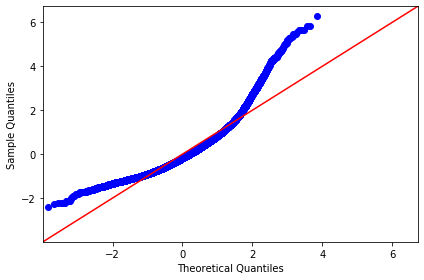

SQFT_LIVING SQFT_LIVING SQFT_LIVING SQFT_LIVING SQFT_LIVING 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_living
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     8472.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:18:42   Log-Likelihood:            -2.1869e+05
No. Observations:               15984   AIC:                         4.374e+05
Df Residuals:                   15982   BIC:                         4.374e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.9

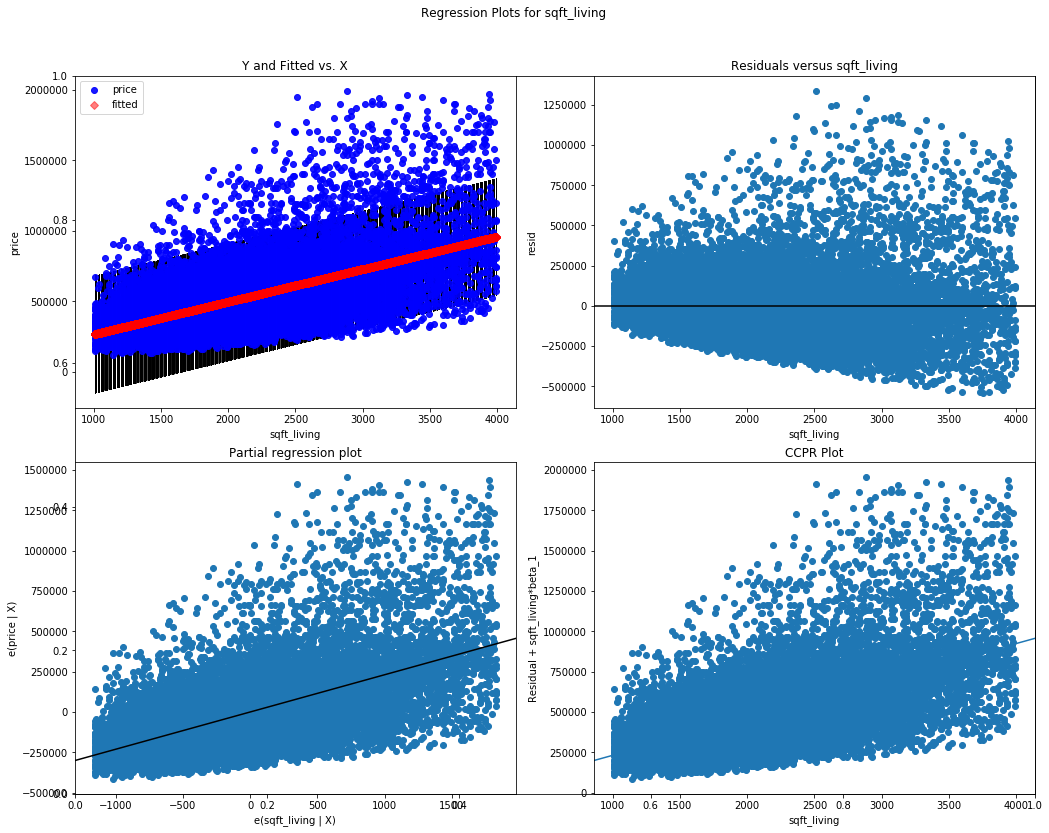

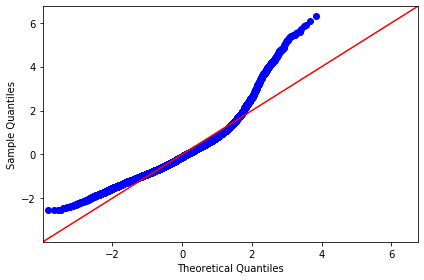

SQFT_LOT SQFT_LOT SQFT_LOT SQFT_LOT SQFT_LOT 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_lot
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     51.46
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           7.61e-13
Time:                        19:18:45   Log-Likelihood:            -2.2206e+05
No. Observations:               15984   AIC:                         4.441e+05
Df Residuals:                   15982   BIC:                         4.441e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

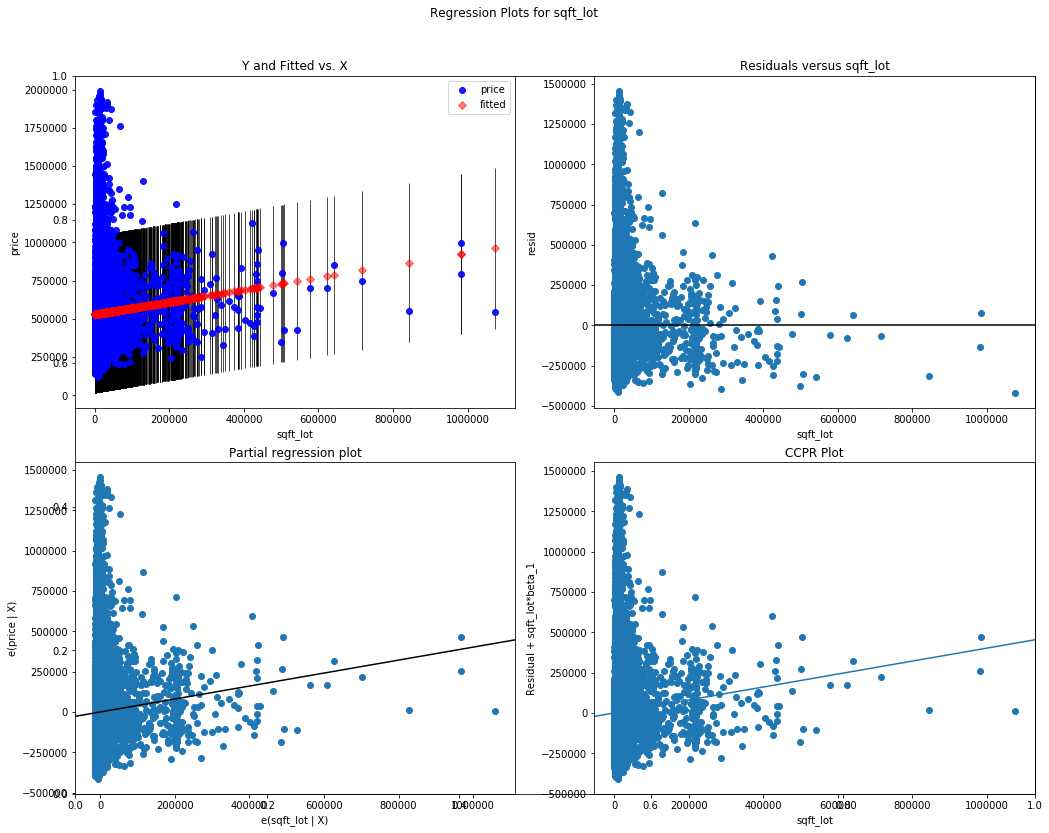

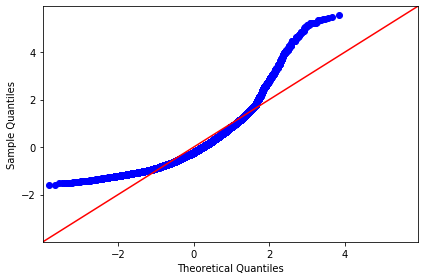

FLOORS FLOORS FLOORS FLOORS FLOORS 
Housing Data - Regression Analysis and Diagnostics for Price~floors
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     472.8
Date:                Thu, 16 Jul 2020   Prob (F-statistic):          2.49e-103
Time:                        19:18:48   Log-Likelihood:            -2.2185e+05
No. Observations:               15984   AIC:                         4.437e+05
Df Residuals:                   15982   BIC:                         4.437e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

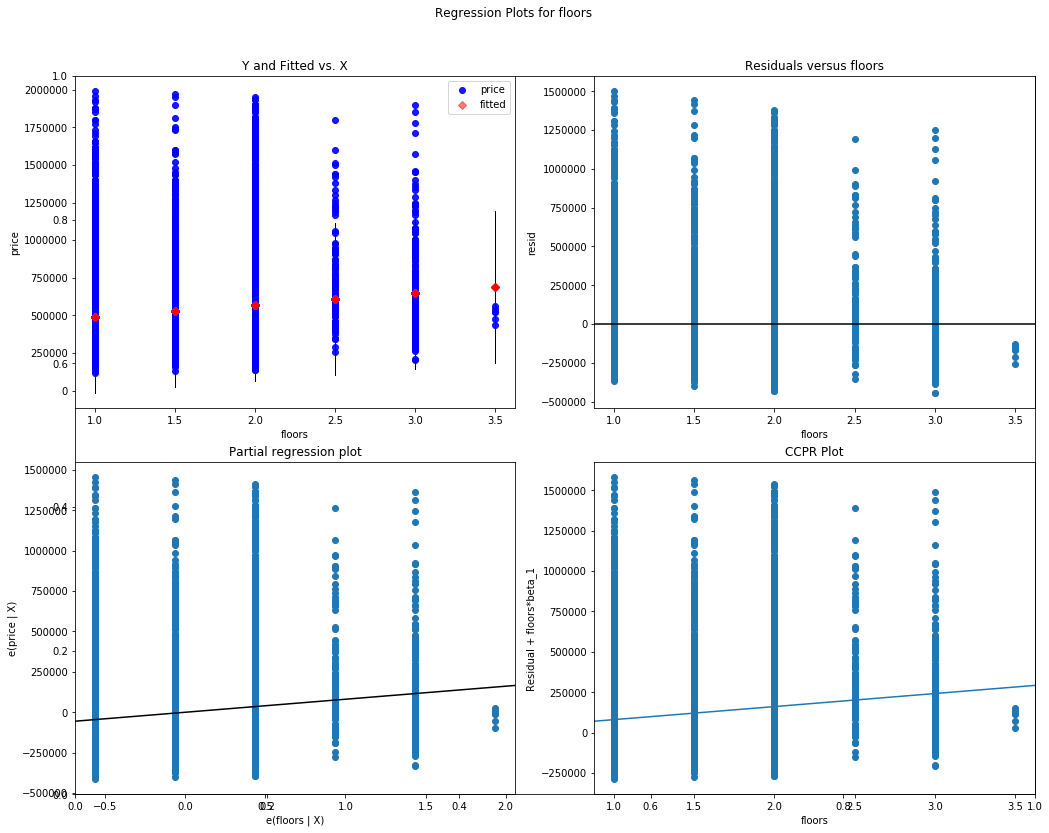

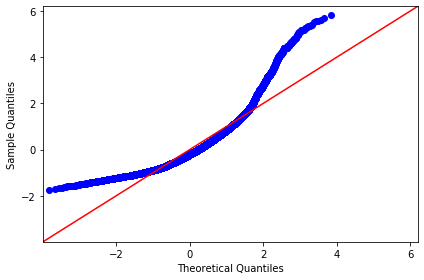

WATERFRONT WATERFRONT WATERFRONT WATERFRONT WATERFRONT 
Housing Data - Regression Analysis and Diagnostics for Price~waterfront
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     408.7
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           9.30e-90
Time:                        19:18:54   Log-Likelihood:            -2.2188e+05
No. Observations:               15984   AIC:                         4.438e+05
Df Residuals:                   15982   BIC:                         4.438e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

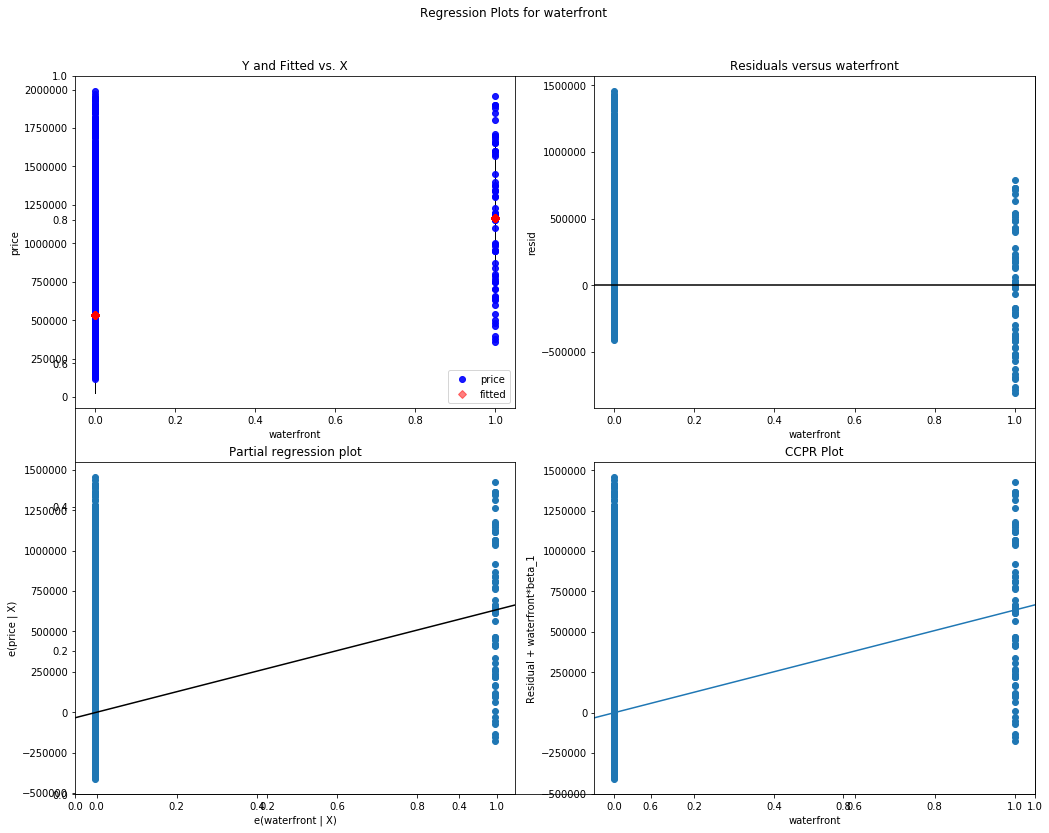

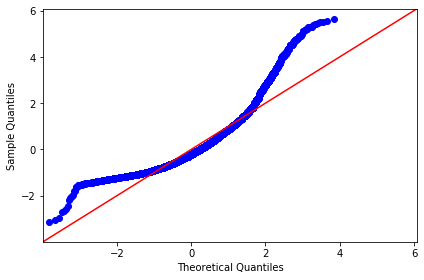

VIEW VIEW VIEW VIEW VIEW 
Housing Data - Regression Analysis and Diagnostics for Price~view
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     1932.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:18:56   Log-Likelihood:            -2.2117e+05
No. Observations:               15984   AIC:                         4.424e+05
Df Residuals:                   15982   BIC:                         4.424e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

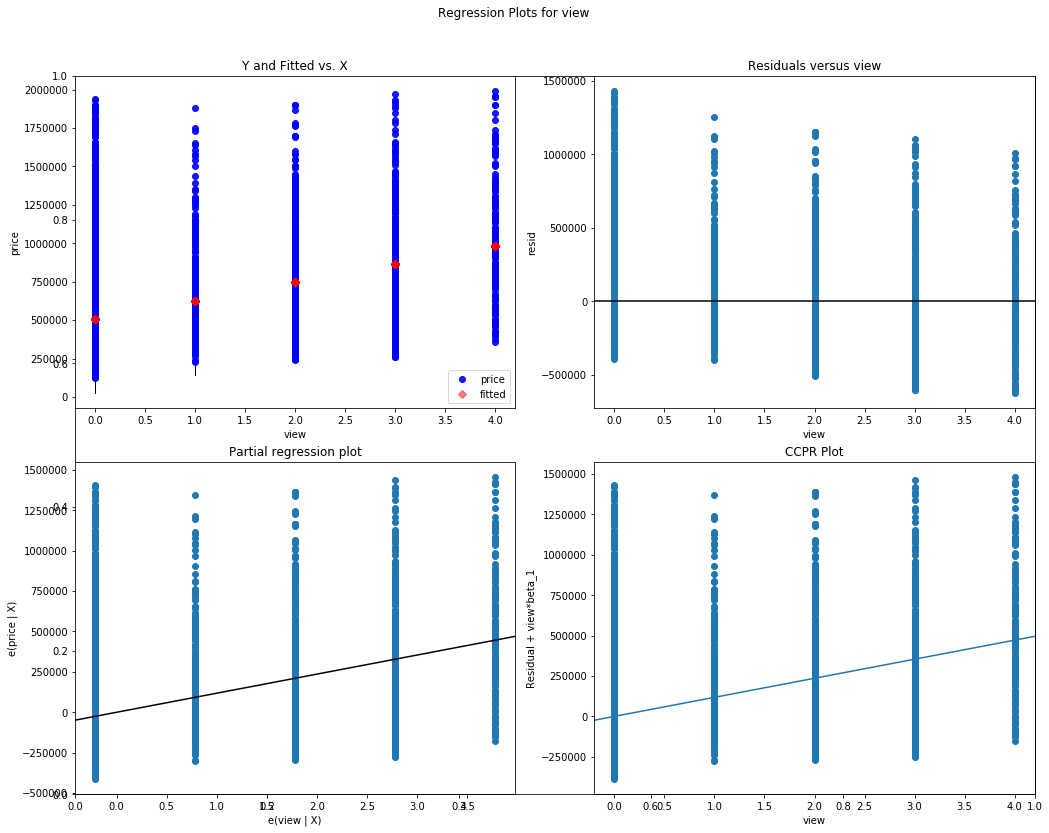

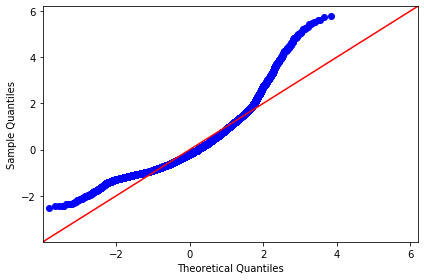

CONDITION CONDITION CONDITION CONDITION CONDITION 
Housing Data - Regression Analysis and Diagnostics for Price~condition
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     81.76
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           1.71e-19
Time:                        19:18:59   Log-Likelihood:            -2.2205e+05
No. Observations:               15984   AIC:                         4.441e+05
Df Residuals:                   15982   BIC:                         4.441e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

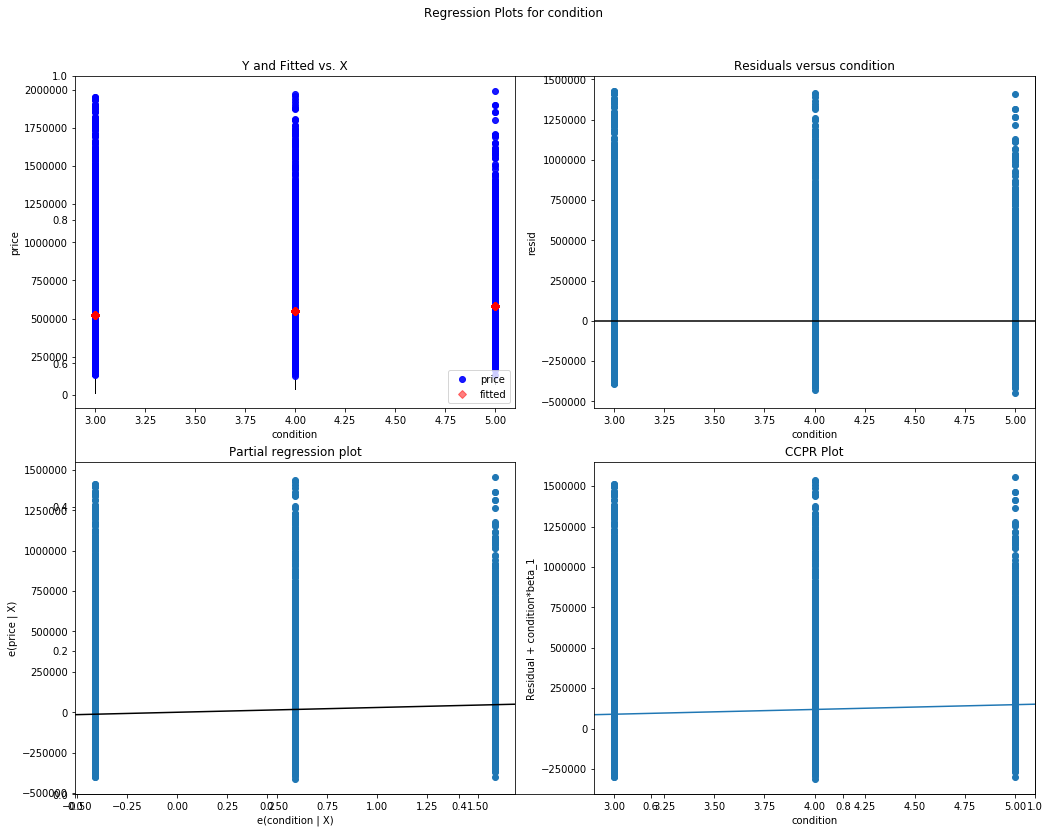

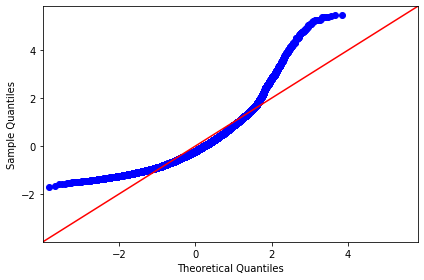

GRADE GRADE GRADE GRADE GRADE 
Housing Data - Regression Analysis and Diagnostics for Price~grade
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     9221.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:19:01   Log-Likelihood:            -2.1845e+05
No. Observations:               15984   AIC:                         4.369e+05
Df Residuals:                   15982   BIC:                         4.369e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

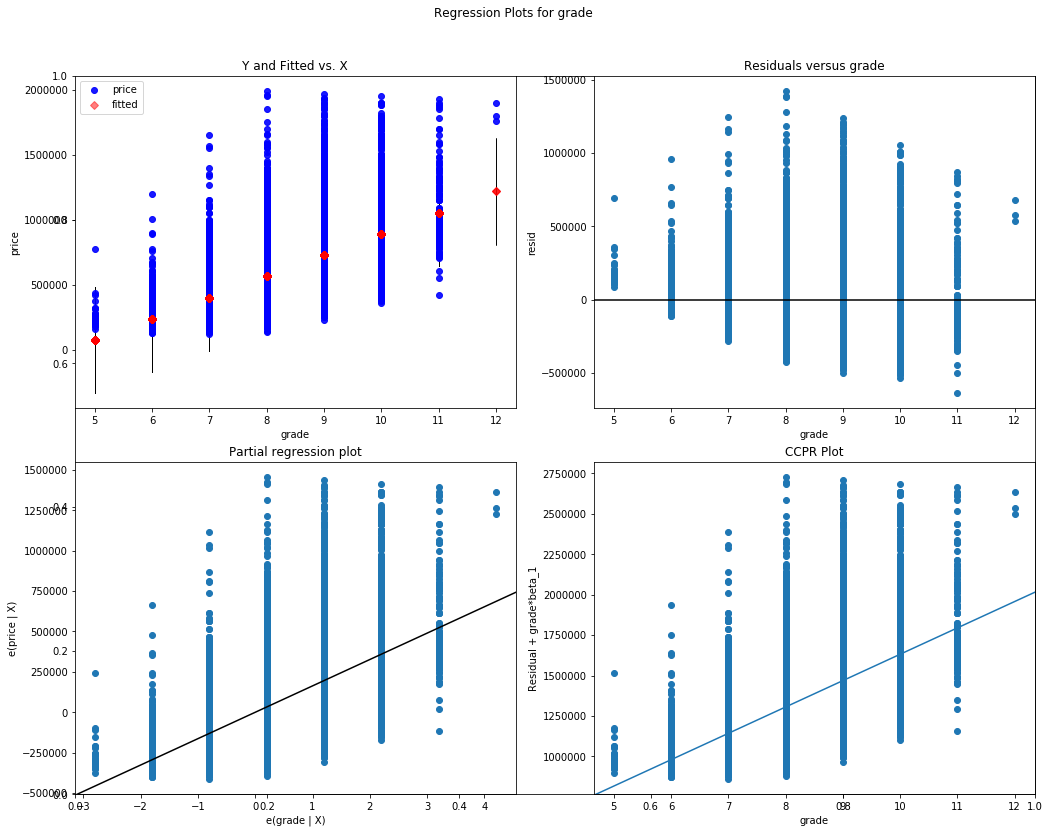

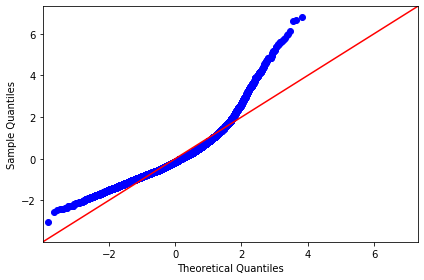

SQFT_ABOVE SQFT_ABOVE SQFT_ABOVE SQFT_ABOVE SQFT_ABOVE 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_above
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     4017.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:19:03   Log-Likelihood:            -2.2029e+05
No. Observations:               15984   AIC:                         4.406e+05
Df Residuals:                   15982   BIC:                         4.406e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

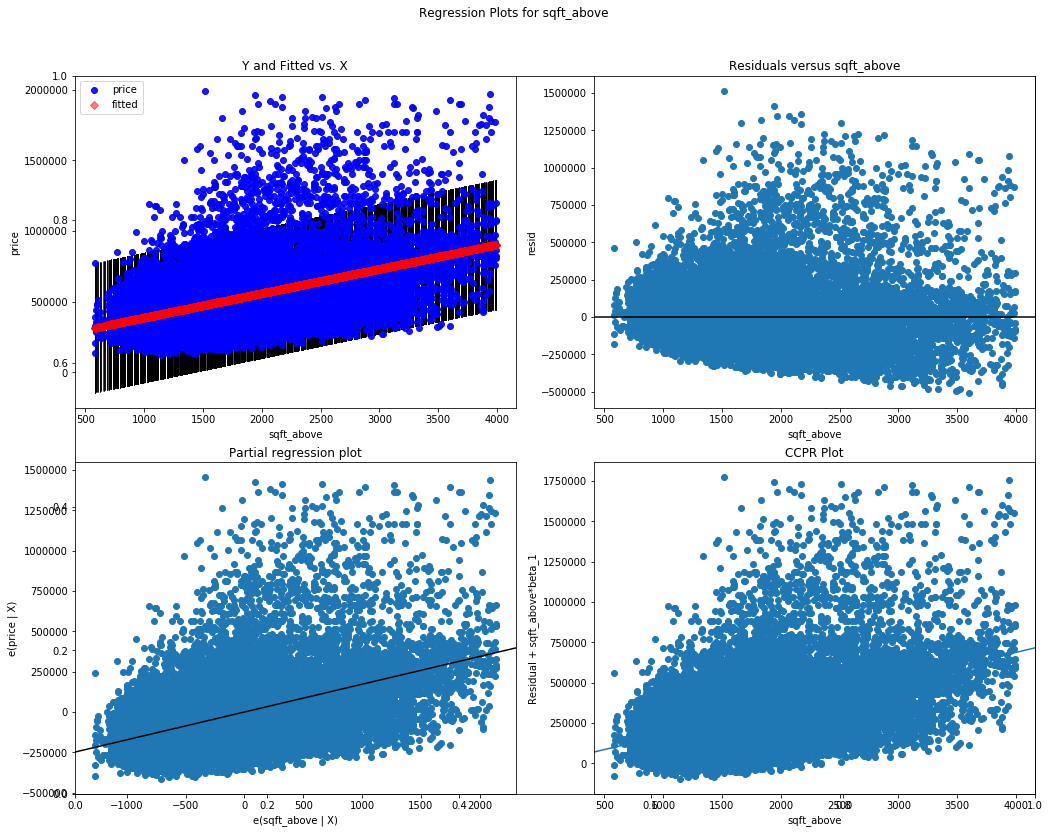

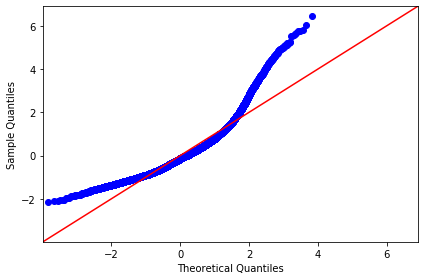

SQFT_BASEMENT SQFT_BASEMENT SQFT_BASEMENT SQFT_BASEMENT SQFT_BASEMENT 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_basement
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     704.7
Date:                Thu, 16 Jul 2020   Prob (F-statistic):          5.48e-152
Time:                        19:19:05   Log-Likelihood:            -2.2174e+05
No. Observations:               15984   AIC:                         4.435e+05
Df Residuals:                   15982   BIC:                         4.435e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [

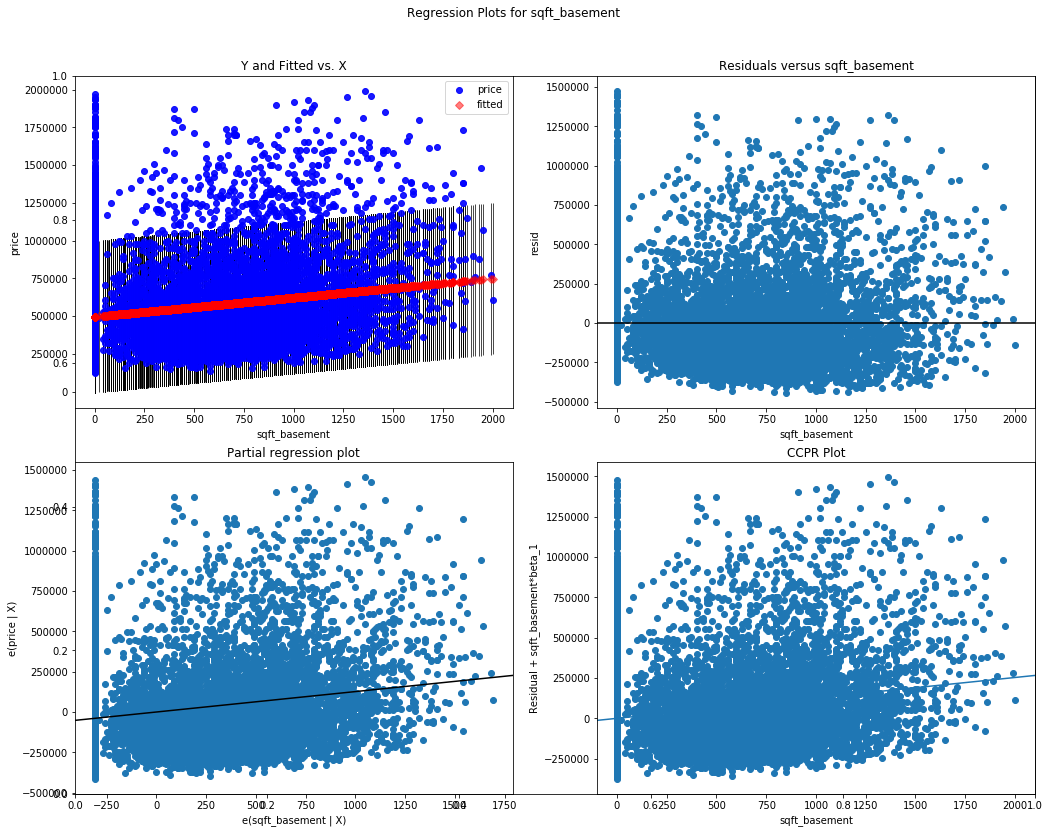

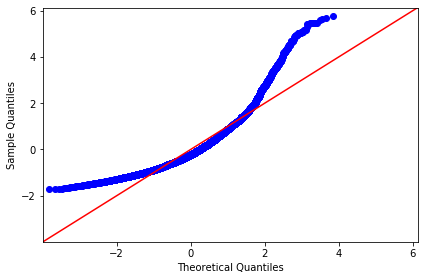

YR_BUILT YR_BUILT YR_BUILT YR_BUILT YR_BUILT 
Housing Data - Regression Analysis and Diagnostics for Price~yr_built
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     173.4
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           2.20e-39
Time:                        19:19:12   Log-Likelihood:            -2.2200e+05
No. Observations:               15984   AIC:                         4.440e+05
Df Residuals:                   15982   BIC:                         4.440e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

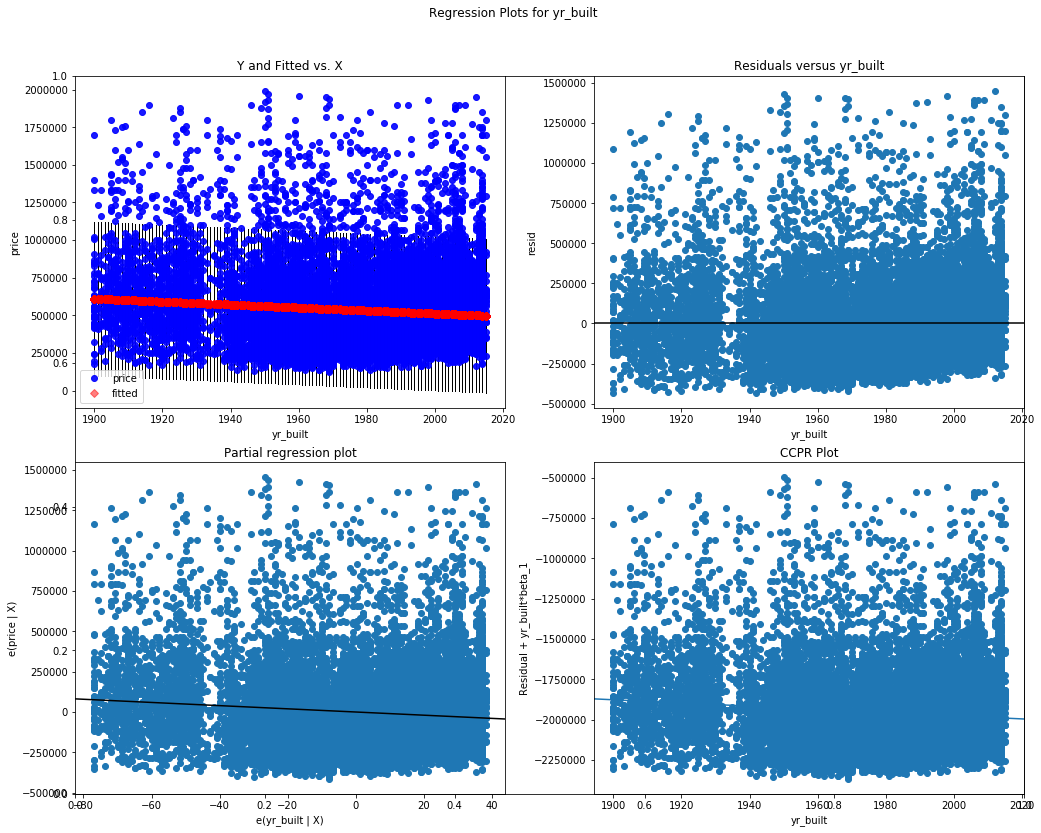

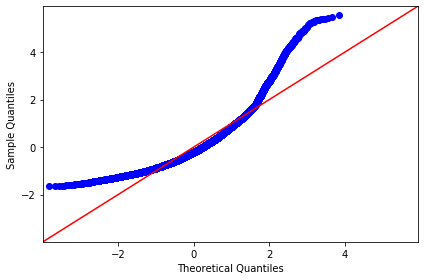

YR_RENOVATED YR_RENOVATED YR_RENOVATED YR_RENOVATED YR_RENOVATED 
Housing Data - Regression Analysis and Diagnostics for Price~yr_renovated
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     48.12
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           4.17e-12
Time:                        19:19:15   Log-Likelihood:            -2.2206e+05
No. Observations:               15984   AIC:                         4.441e+05
Df Residuals:                   15982   BIC:                         4.441e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025  

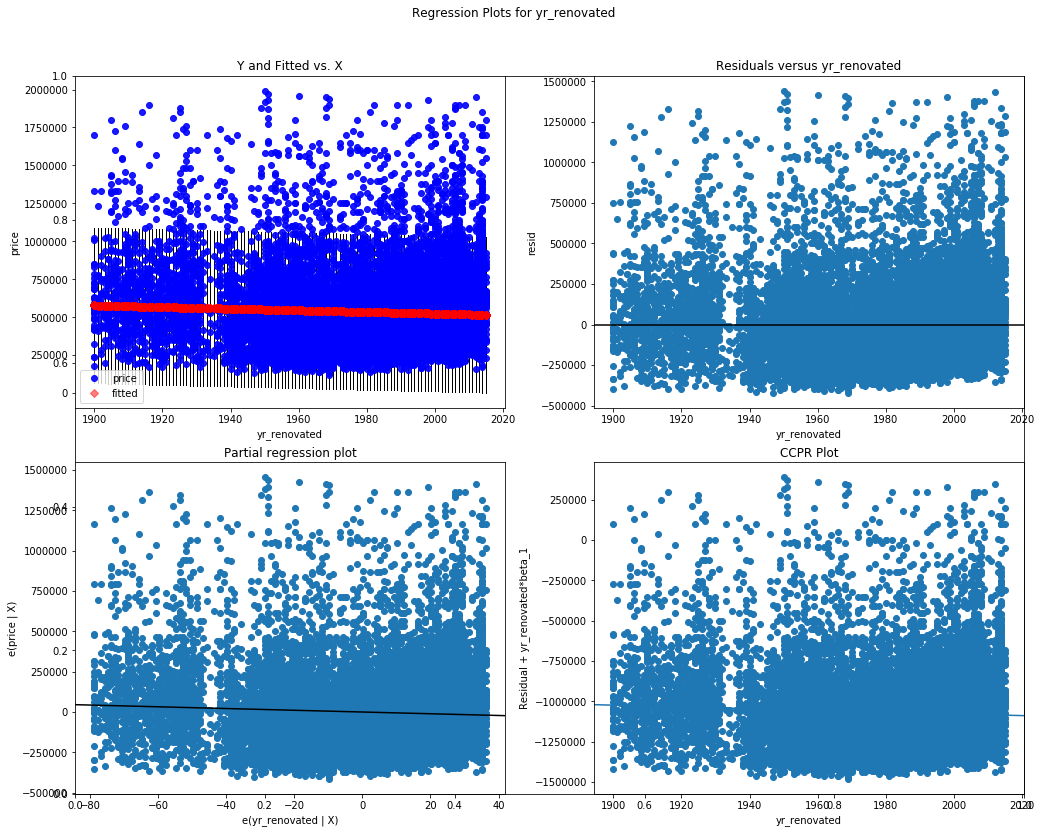

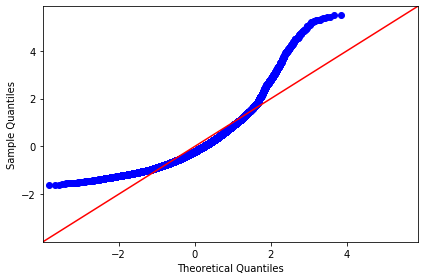

SQFT_LIVING15 SQFT_LIVING15 SQFT_LIVING15 SQFT_LIVING15 SQFT_LIVING15 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_living15
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     5615.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:19:26   Log-Likelihood:            -2.1968e+05
No. Observations:               15984   AIC:                         4.394e+05
Df Residuals:                   15982   BIC:                         4.394e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [

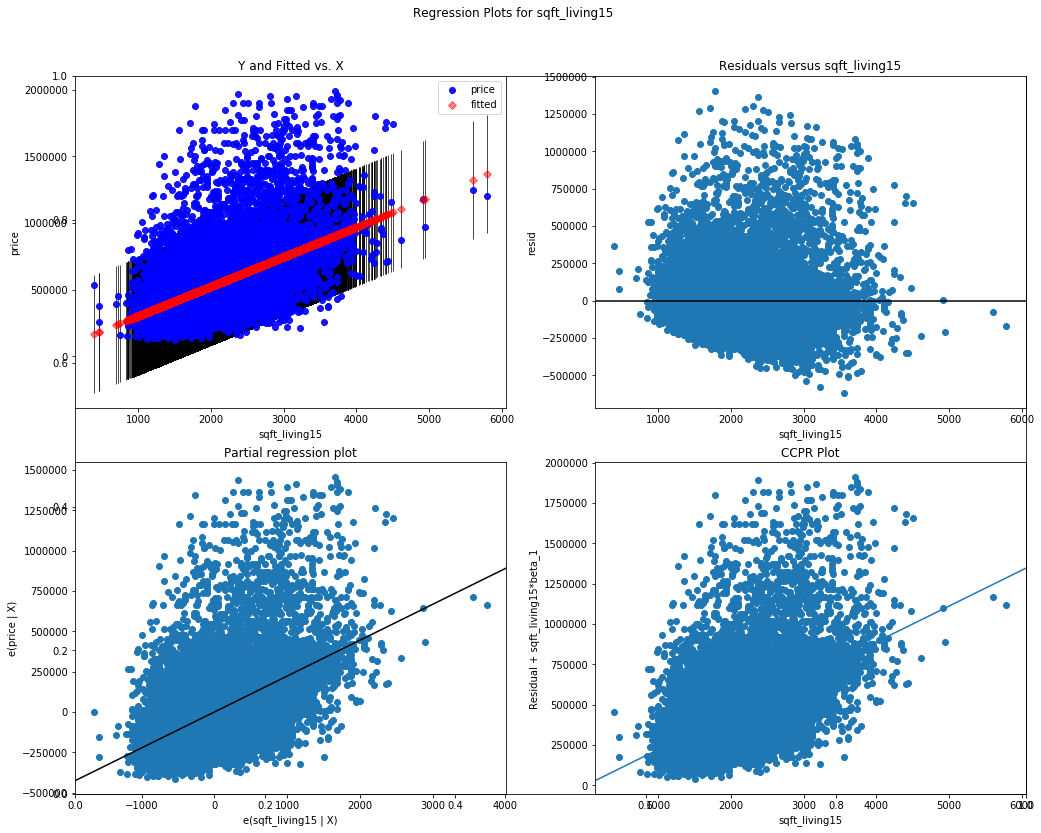

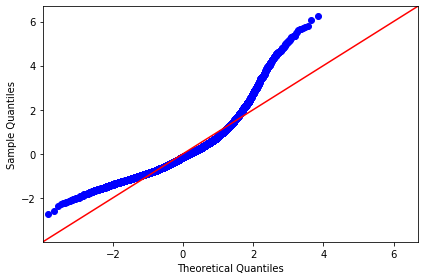

SQFT_LOT15 SQFT_LOT15 SQFT_LOT15 SQFT_LOT15 SQFT_LOT15 
Housing Data - Regression Analysis and Diagnostics for Price~sqft_lot15
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     39.61
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           3.19e-10
Time:                        19:19:28   Log-Likelihood:            -2.2207e+05
No. Observations:               15984   AIC:                         4.441e+05
Df Residuals:                   15982   BIC:                         4.442e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

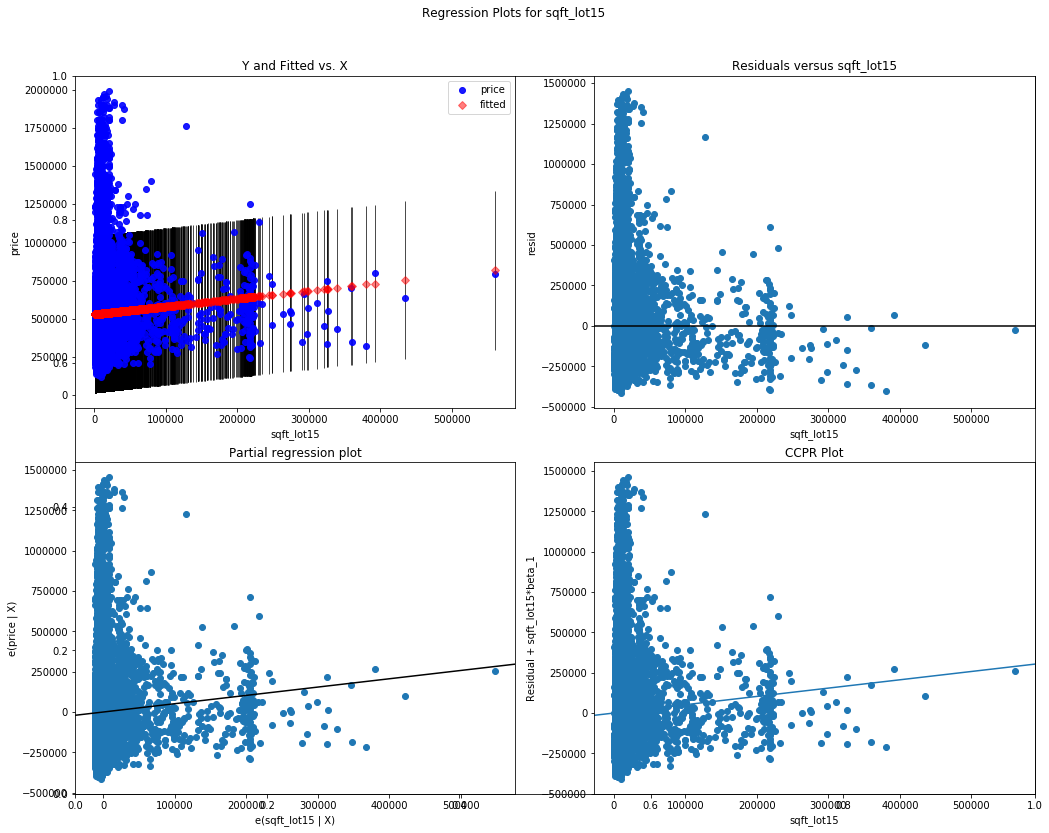

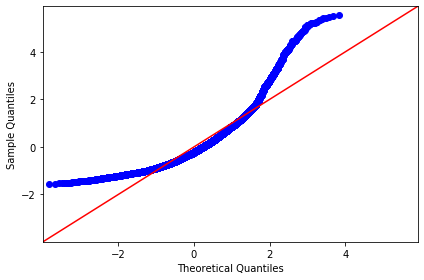

MONTH MONTH MONTH MONTH MONTH 
Housing Data - Regression Analysis and Diagnostics for Price~month
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.83
Date:                Thu, 16 Jul 2020   Prob (F-statistic):            0.00100
Time:                        19:19:32   Log-Likelihood:            -2.2208e+05
No. Observations:               15984   AIC:                         4.442e+05
Df Residuals:                   15982   BIC:                         4.442e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

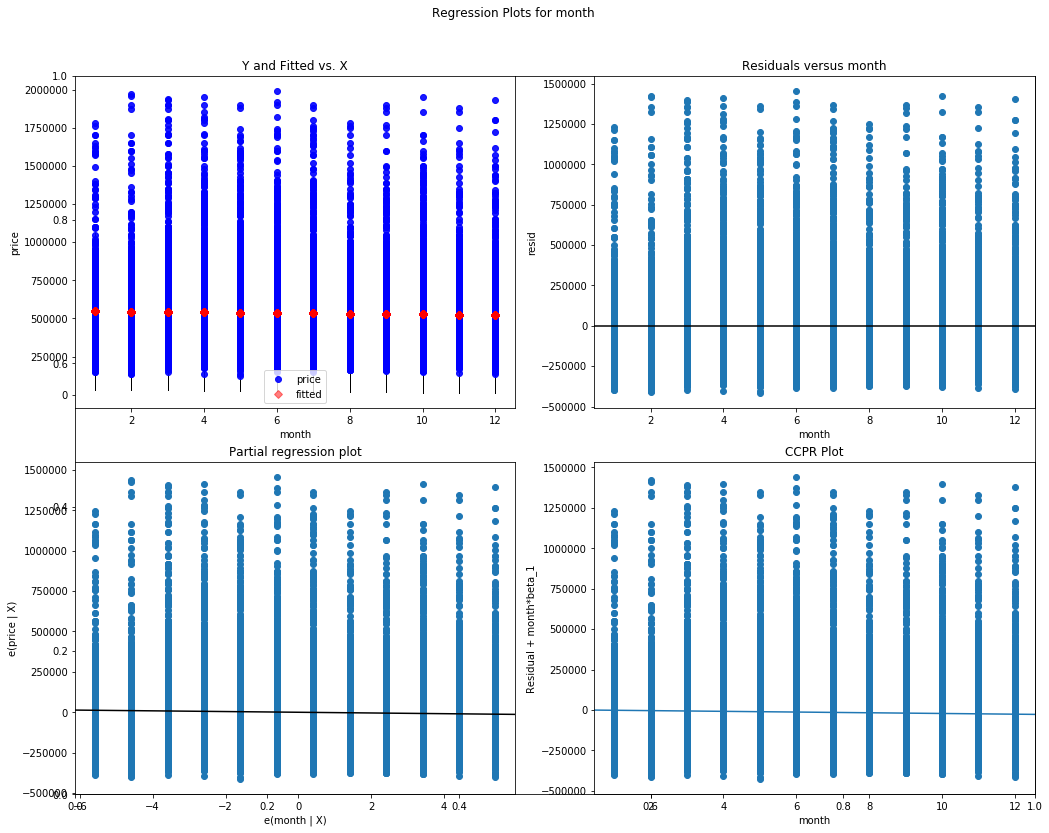

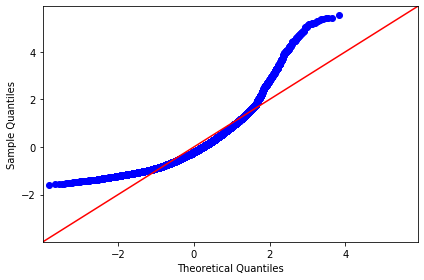

SCHOOL_SCORE SCHOOL_SCORE SCHOOL_SCORE SCHOOL_SCORE SCHOOL_SCORE 
Housing Data - Regression Analysis and Diagnostics for Price~school_score
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     4288.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:19:34   Log-Likelihood:            -2.2019e+05
No. Observations:               15984   AIC:                         4.404e+05
Df Residuals:                   15982   BIC:                         4.404e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025  

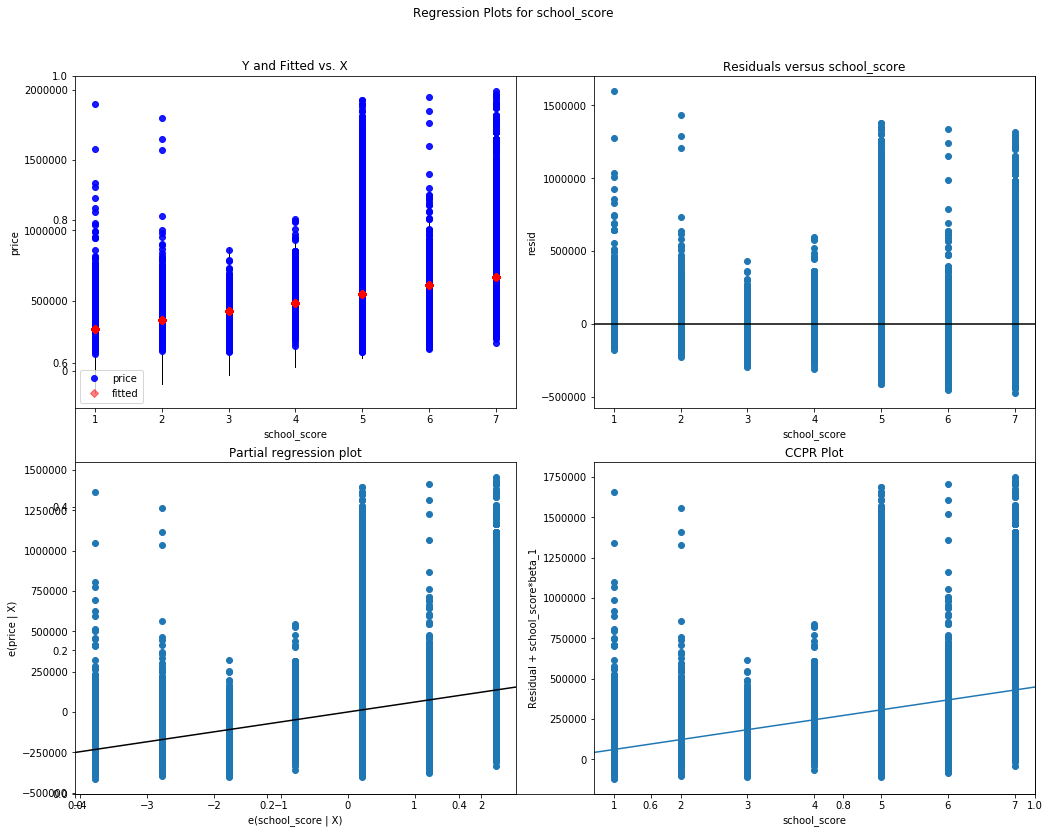

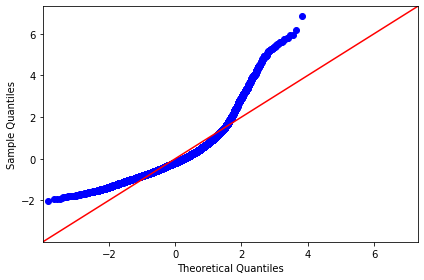

NEAREST_WATER NEAREST_WATER NEAREST_WATER NEAREST_WATER NEAREST_WATER 
Housing Data - Regression Analysis and Diagnostics for Price~nearest_water
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     1391.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):          4.63e-292
Time:                        19:19:39   Log-Likelihood:            -2.2142e+05
No. Observations:               15984   AIC:                         4.428e+05
Df Residuals:                   15982   BIC:                         4.429e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [

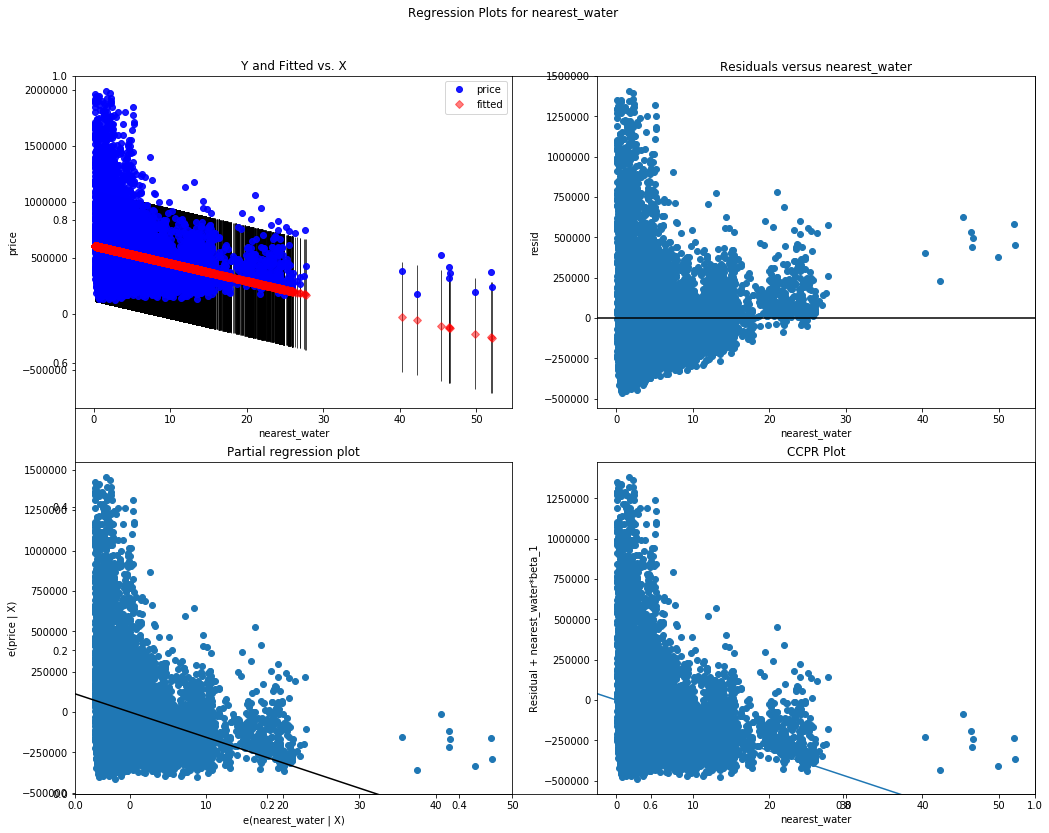

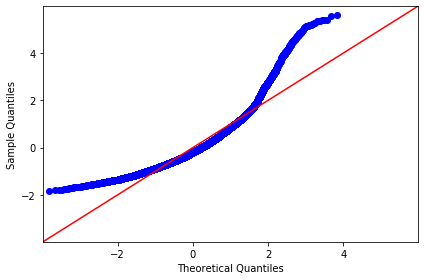

DOWNTOWN_DIST DOWNTOWN_DIST DOWNTOWN_DIST DOWNTOWN_DIST DOWNTOWN_DIST 
Housing Data - Regression Analysis and Diagnostics for Price~downtown_dist
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     1537.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):          5.00e-321
Time:                        19:19:41   Log-Likelihood:            -2.2135e+05
No. Observations:               15984   AIC:                         4.427e+05
Df Residuals:                   15982   BIC:                         4.427e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [

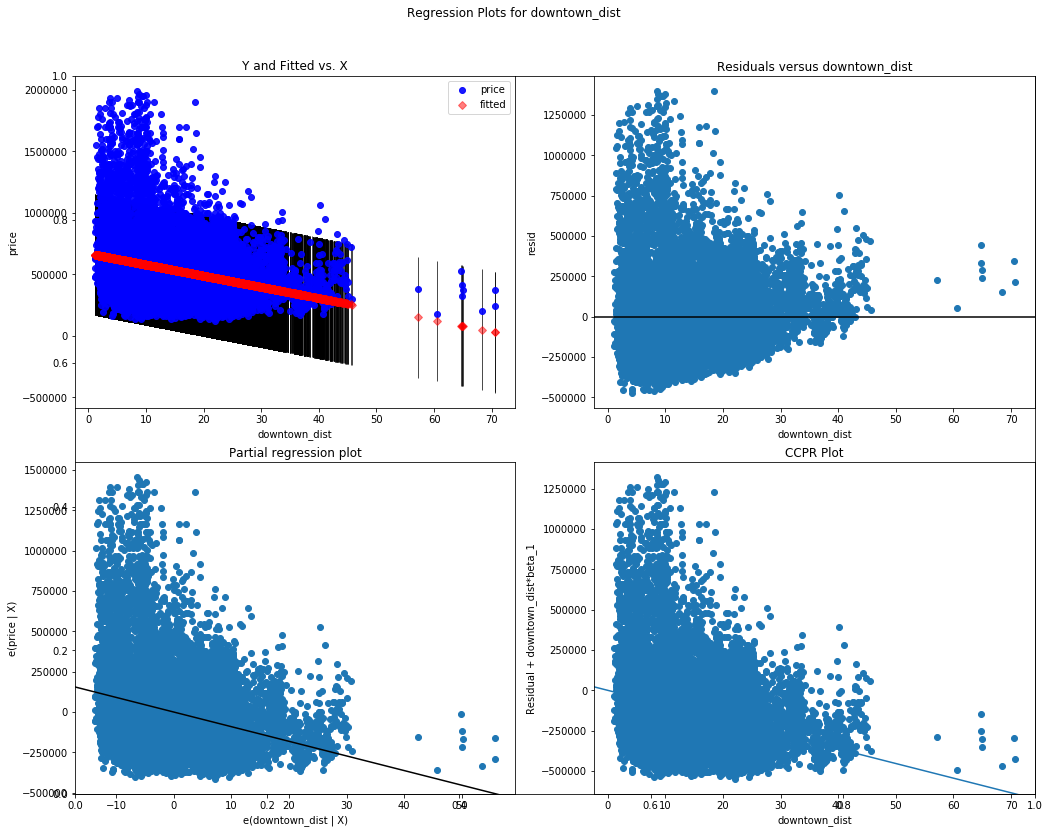

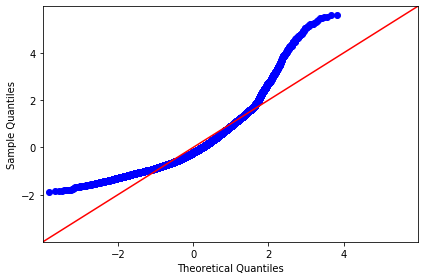

NEAREST_BUCKS NEAREST_BUCKS NEAREST_BUCKS NEAREST_BUCKS NEAREST_BUCKS 
Housing Data - Regression Analysis and Diagnostics for Price~nearest_bucks
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     41.34
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           1.32e-10
Time:                        19:19:45   Log-Likelihood:            -2.2207e+05
No. Observations:               15984   AIC:                         4.441e+05
Df Residuals:                   15982   BIC:                         4.441e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [

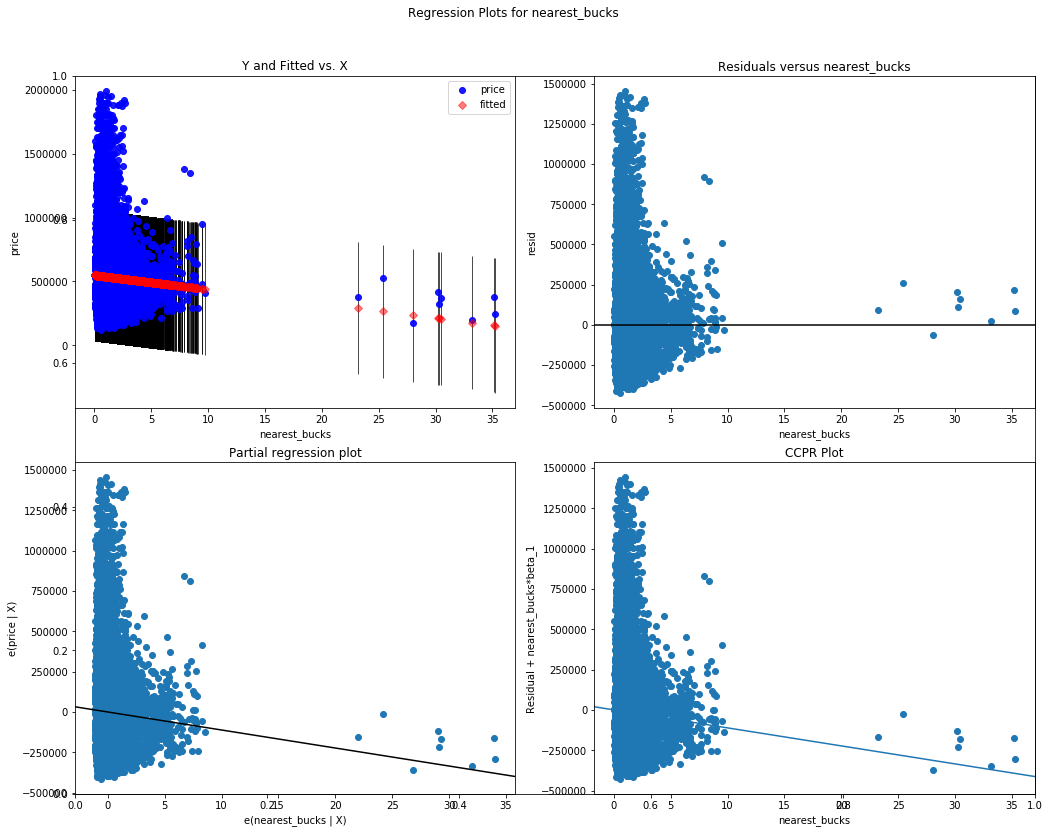

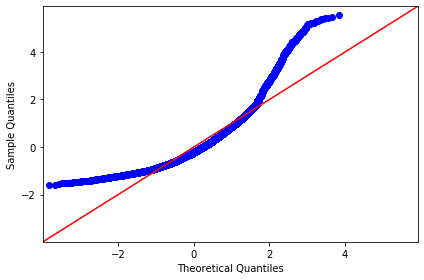

QUARTER QUARTER QUARTER QUARTER QUARTER 
Housing Data - Regression Analysis and Diagnostics for Price~quarter
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.46
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           0.000714
Time:                        19:19:47   Log-Likelihood:            -2.2208e+05
No. Observations:               15984   AIC:                         4.442e+05
Df Residuals:                   15982   BIC:                         4.442e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

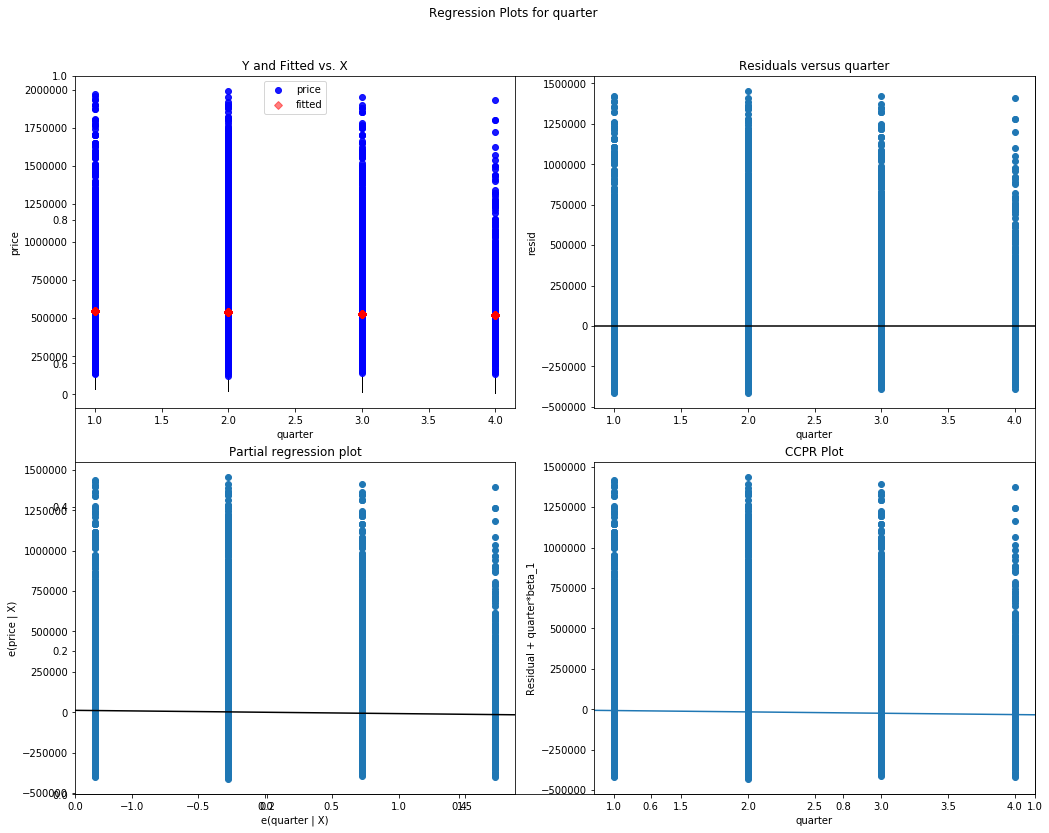

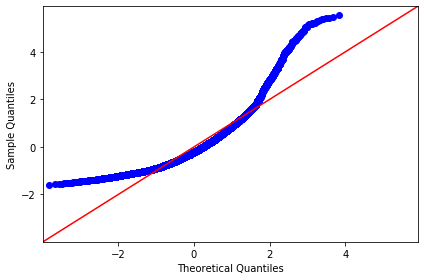

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
15,month,0.000677,5.493853e+05,-2199.372690,1.000137e-03,16613.027053
20,quarter,0.000716,5.538725e+05,-8342.650329,7.139231e-04,16587.886320
14,sqft_lot15,0.002472,5.284411e+05,0.515311,3.187404e-10,16963.342426
19,nearest_bucks,0.002580,5.481204e+05,-11162.669075,1.315563e-10,16580.019266
12,yr_renovated,0.003002,1.600909e+06,-538.739206,4.172279e-12,16574.209987
3,sqft_lot,0.003210,5.290471e+05,0.402061,7.612799e-13,17112.845668
7,condition,0.005090,4.341774e+05,29528.402371,1.708472e-19,16401.559194
11,yr_built,0.010730,2.487167e+06,-987.602652,2.195745e-39,16330.668984
5,waterfront,0.024935,5.321921e+05,635160.059363,9.297305e-90,15138.480988
4,floors,0.028732,4.088189e+05,80597.896388,2.485923e-103,17100.280003


In [799]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# I don't need to see regression analysis for all of my variables
drops = ['date', 
         'longlat', 
         'points', 
         'school_district', 
         'lat', 
         'long',
         'zipcode',
         'id',
         'price'
        ]

results = []
for idx, column in enumerate(kc2.drop(columns=drops, axis=1).columns):
    
    print((column.upper() + " ") * 5)
    print (f"Housing Data - Regression Analysis and Diagnostics for Price~{column}")
    
    f = f'price~{column}'  # create my model formula
    model = smf.ols(formula=f, data=kc2).fit()  # fit the model
    print(model.summary())
    
    fig, axes = plt.subplots(figsize=(15,12))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')

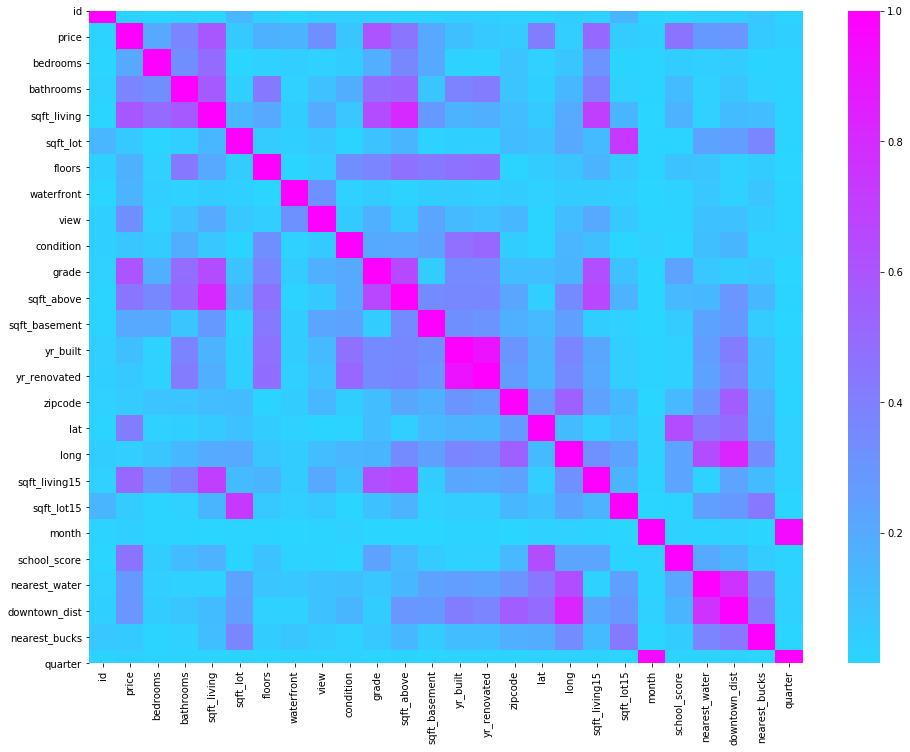

In [800]:
kc_features = kc2.copy()
plt.figure(figsize = (16,12))
sns.heatmap(abs(kc_features.corr()), center=0.4, cmap = "cool");




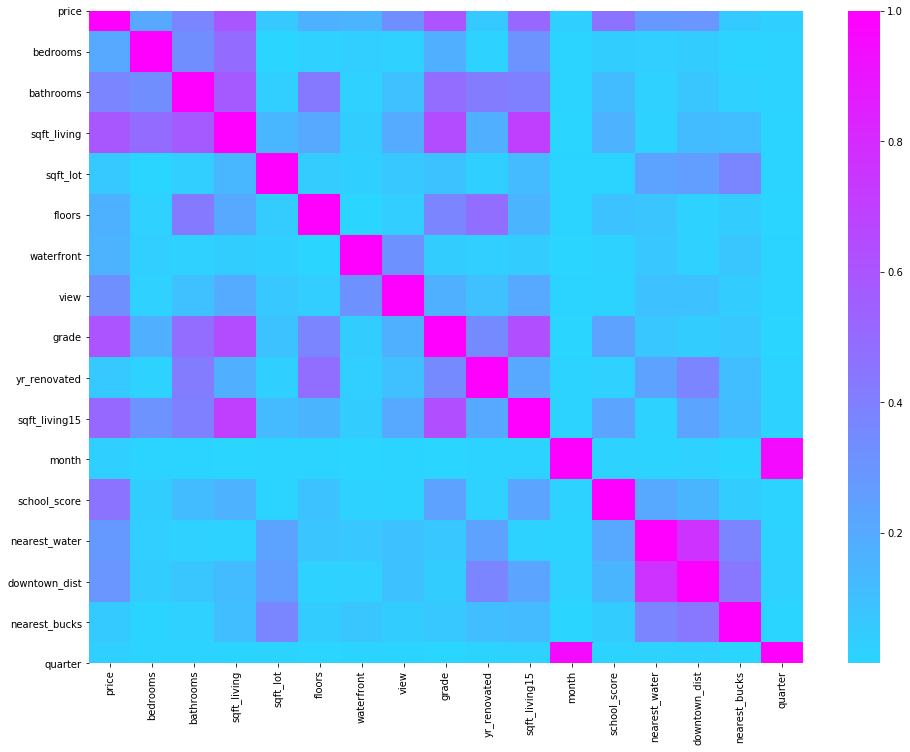

In [801]:
kc_features = kc2.drop(['sqft_above', 'sqft_lot15', 'sqft_lot15', 'yr_built', 'id', 'lat', 'long'
                    , 'sqft_basement', 'zipcode', 'condition'], axis=1)
plt.figure(figsize = (16,12))
sns.heatmap(abs(kc_features.corr()), center=0.4, cmap = "cool");


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff53d2b2d68>,
      dtype=object)

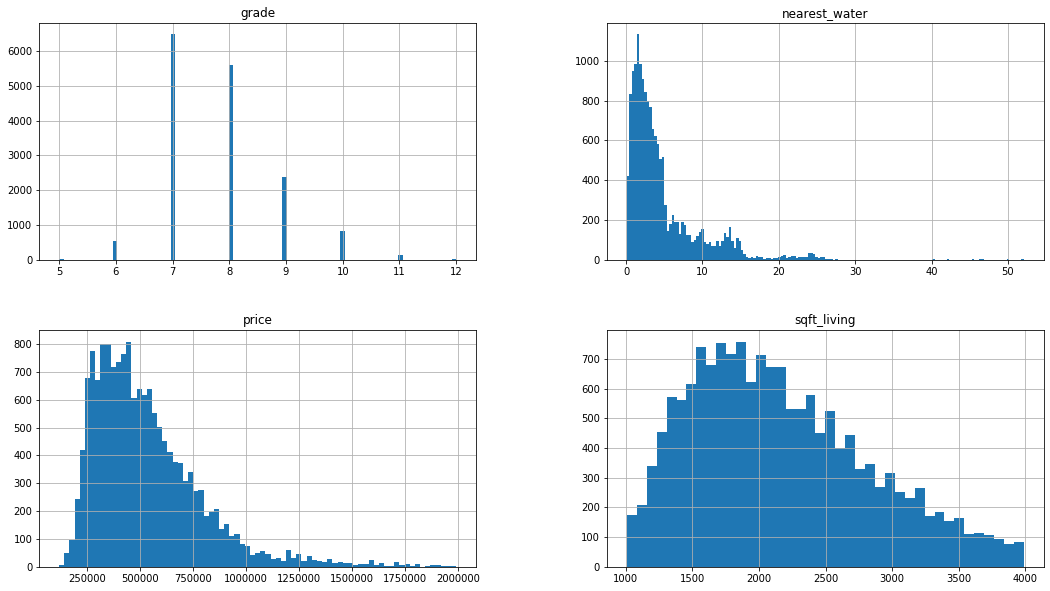

In [828]:
# CHoose the features to use

continuous = ['price', 'sqft_living', 'grade', 'nearest_water']
categoricals = ['view', 'school_score']

kc_cont = kc_features[continuous]
kc_cont.hist(figsize=[18,10], bins='auto')


## Log and normalize features as needed

/Users/aaronlee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


   price_log  sqft_living_log  grade_log  nearest_water_log
1  13.195614         7.851661   1.945910           0.982816
3  13.311329         7.580700   1.945910          -0.822008
4  13.142166         7.426549   2.079442           0.551581
7  12.583995         6.966024   1.945910           0.592667
9  12.685408         7.544332   1.945910           2.597200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff55292d080>,
      dtype=object)

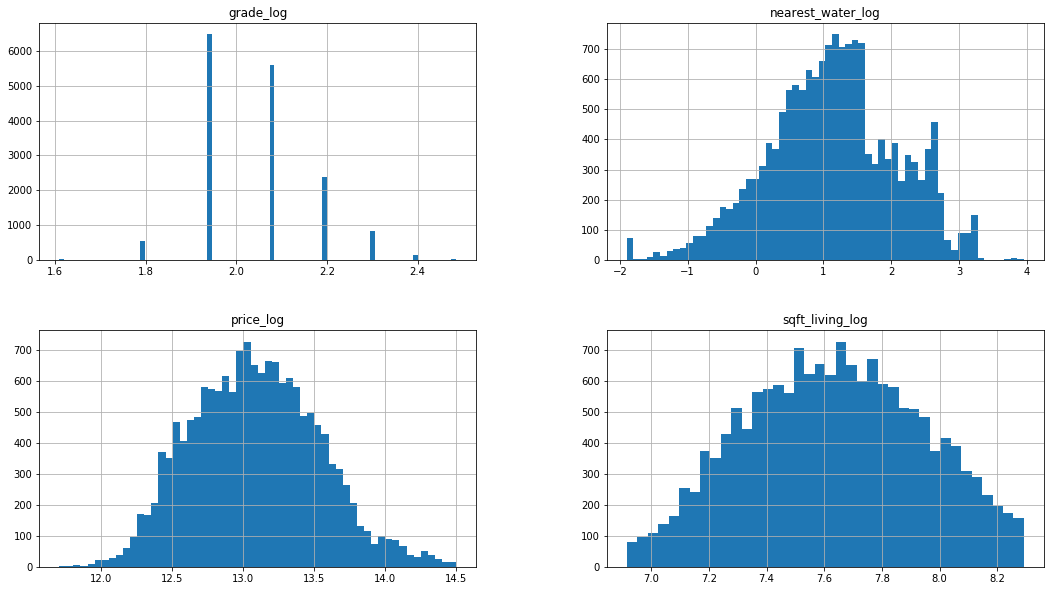

In [829]:
# Start by not doing any normalization


# # log features
log_names = ['{}_log'.format(column) for column in kc_cont.columns]

# # divide by zero if I log zero
kc_cont['nearest_water'] = kc_cont['nearest_water'] + 0.05


kc_cont_log = np.log(kc_cont)
kc_cont_log.columns = log_names
print(kc_cont_log.head())

kc_cont_log.hist(figsize=[18,10], bins='auto')

In [830]:
# normalize (subract mean and divide by std)
# def normalize(feature):
#     # returns a normalized standard score between 
#     return (feature - feature.mean()) / feature.std()


# kc_log_norm = kc_cont_log.apply(normalize)
# kc_log_norm.hist(figsize=[18,10], bins='auto')




In [838]:
from functools import reduce

kc2[categoricals].nunique()


# Thought this would work, but failed.  Prefix len problem
# dummies = pd.get_dummies(kc[categorical[0]], prefix=categorical[0], drop_first=True)
# dummies


def add_dummies(df, cats):
    dummies = []
    for cat in cats:
        dummy = pd.get_dummies(df[cat], prefix=cat, drop_first=True)
        dummies.append(dummy)

    dummies_df = pd.concat(dummies, axis=1, sort=False)                   
    return dummies_df

                       
# one hot encode categoricals
kc_ohe = add_dummies(kc2, categoricals)
                       
preprocessed = pd.concat([kc_cont, kc_ohe], axis=1)
#preprocessed = kc_cont.copy() # FOR TROUBLESHOOTING

preprocessed.describe()


,price,sqft_living,grade,nearest_water,view_1.0,view_2.0,view_3.0,view_4.0,school_score_2.0,school_score_3.0,school_score_4.0,school_score_5.0,school_score_6.0,school_score_7.0
count,1.598400e+04,15984.000000,15984.000000,15984.000000,15984.000000,15984.000000,15984.000000,15984.000000,15984.000000,15984.000000,15984.000000,15984.000000,15984.000000,15984.000000
mean,5.348943e+05,2162.462025,7.799737,4.720783,0.016141,0.044107,0.022710,0.011324,0.073886,0.108296,0.051489,0.279592,0.122685,0.267705
std,2.618057e+05,667.412396,0.970502,4.712117,0.126022,0.205338,0.148983,0.105813,0.261594,0.310763,0.221000,0.448813,0.328086,0.442777
min,1.207500e+05,1008.000000,5.000000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.475000e+05,1640.000000,7.000000,1.682640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.751000e+05,2060.000000,8.000000,3.127095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.540750e+05,2600.000000,8.000000,5.784591,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.990000e+06,3990.000000,12.000000,52.134418,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [839]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

regression = LinearRegression()

X = preprocessed.drop('price', axis=1)
y = preprocessed['price']

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))


#preprocessed.columns 
baseline


0.6707504623560681

In [840]:
regression.fit(X, y)
coefficients = dict(zip(X.columns,list(regression.coef_)))
coefficients


{'sqft_living': 139.78771425800292,
 'grade': 73168.32032734621,
 'nearest_water': -5318.348390548316,
 'view_1.0': 94122.09972254673,
 'view_2.0': 86998.04792807462,
 'view_3.0': 156223.18428785398,
 'view_4.0': 352231.9466934631,
 'school_score_2.0': 73551.60221321968,
 'school_score_3.0': 29404.03543622979,
 'school_score_4.0': 168114.64985860864,
 'school_score_5.0': 281700.1961381479,
 'school_score_6.0': 128931.42119234611,
 'school_score_7.0': 259044.25782135883}

In [808]:
# !pip install geopy

preprocessed['price']
preprocessed.iloc[0]

price            538000.00000
sqft_living        2570.00000
grade                 7.00000
school_score          5.00000
nearest_water         2.67197
view_1.0              0.00000
view_2.0              0.00000
view_3.0              0.00000
view_4.0              0.00000
Name: 1, dtype: float64

In [809]:
# FEATURE SELECTION


import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.01, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [810]:
keepers = stepwise_selection(X, y)

/Users/aaronlee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  school_score                   with p-value 0.0
Add  grade                          with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  nearest_water                  with p-value 1.07876e-297
Add  view_4.0                       with p-value 1.42179e-166
Add  view_3.0                       with p-value 5.70904e-91
Add  view_2.0                       with p-value 5.51008e-73
Add  view_1.0                       with p-value 8.22386e-28


In [811]:

yhat = regression.predict(X)
sum_squares_residual = np.sum((y - yhat)**2)
sum_squares_total = np.sum((y - np.mean(y))**2)

r_squared = 1 - (float(sum_squares_residual)) / sum_squares_total
adj_r_squared = 1 - (1 - r_squared)*(len(y) - 1) / (len(y) - X.shape[1] - 1)

print('r_squared: {}\nadj_r_squared: {}'.format(r_squared, adj_r_squared))


r_squared: 0.6154465075903913
adj_r_squared: 0.6152539299416103


In [812]:
# Drop the columns from stepwise feature elimination
X = X[keepers]
X.columns

Index(['school_score', 'grade', 'sqft_living', 'nearest_water', 'view_4.0',
       'view_3.0', 'view_2.0', 'view_1.0'],
      dtype='object')

In [813]:
# Refit it and try again
regression.fit(X, y)


yhat = regression.predict(X)
sum_squares_residual = np.sum((y - yhat)**2)
sum_squares_total = np.sum((y - np.mean(y))**2)

r_squared = 1 - (float(sum_squares_residual)) / sum_squares_total
adj_r_squared = 1 - (1 - r_squared)*(len(y) - 1) / (len(y) - X.shape[1] - 1)

print('r_squared: {}\nadj_r_squared: {}'.format(r_squared, adj_r_squared))

r_squared: 0.6154465075903914
adj_r_squared: 0.6152539299416104


In [814]:
import geopy
import os


with open(os.path.expanduser('~/.secret/smarty_streets.json')) as f:
  keys = json.load(f)



address = '16613 SE 16th St, Bellevue'


In [815]:
# Make an intereactive predictor

# import ipywidgets as widgets
# from ipywidgets import interact, interact_manual

# def predict_price(coefs, column1_value, column2_value):
#     display(df.loc[(df['views'] < column1_value) & 
#                     (df['reads'] < column2_value), 
#                    ['title', 'read_time', 'tags', 'views', 'reads']])
        
# column1_value=widgets.IntText(value=100, label='First')
# column2_value=widgets.IntSlider(value=100, label='Second')

# linked = widgets.jslink((column1_value, 'value'),
#                         (column2_value, 'value'))

# less_than = interact(show_less_than, column1_value=column1_value,
#                  column2_value=column2_value)

In [816]:
X.columns

Index(['school_score', 'grade', 'sqft_living', 'nearest_water', 'view_4.0',
       'view_3.0', 'view_2.0', 'view_1.0'],
      dtype='object')

In [817]:
X = preprocessed[keepers]
regression.fit(X, y)
coefficients = list(zip(keepers, regression.coef_))
coefficients

[('school_score', 40786.846935656016),
 ('grade', 76076.3177763561),
 ('sqft_living', 123.65113481415908),
 ('nearest_water', -9717.855739475928),
 ('view_4.0', 371041.1578805984),
 ('view_3.0', 190925.99294702732),
 ('view_2.0', 118068.57211440377),
 ('view_1.0', 112610.74530662863)]

# Model Validation

In [818]:
# MODEL VALIDATION
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
print(len(X_train), len(X_test), len(y_train), len(y_test))


12787 3197 12787 3197


In [819]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [820]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 26249128142.601723
Test Mean Squarred Error: 26816138847.562965


In [821]:
for i in range(10):
    print(regression.predict(X.iloc[[i]])[0], y.iloc[i])


537644.926598317 538000.0
483912.0886846263 604000.0
594341.1012633969 510000.0
196172.42933095247 291850.0
389841.9452938356 323000.0
819985.3867102109 662500.0
479748.96355641575 400000.0
453439.17445285816 530000.0
931887.0855395852 650000.0
340390.17975846445 395000.0


In [822]:
cols = X.columns

In [823]:
# GEOCODING

from geopy import Nominatim
import time



In [824]:
# Find school district
import folium  # for plotting stuff later if needed.   Would be fun to do.
import json

# might not need all of these
from shapely.geometry import Polygon, Point, MultiPolygon, shape, GeometryCollection



my_shapes = "districts.geojson"  # geojson shape file for district boundaries

with open(my_shapes, 'r') as f:
    school_geo_data = json.load(f)


# make a list of the names of the school districts to appy later
dist_names = [x["properties"]["NAME"] for x in school_geo_data['features']]  # It worked!

# NOTE: buffer(0) is a trick for fixing scenarios where polygons have overlapping coordinates 
# We go through every item in the geojson features, and create mappable polygons from it
polygons = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in school_geo_data['features']])
polygons[0]


def make_point(long, lat):
    '''
    Returns a shapely Point object from a latlong location.

            Parameters:
                    latlong (list): iterable of len 2 [lat, long]

            Returns:
                    Point object
    '''
    # note that the point requires (long, lat) or (x, y) format
    return Point(long, lat)


def which_district(point, polygon_list, district_names):
    '''
    Returns the name from district_names list if point is in polygon from polygon_list
            
            Parameters:
                    point (Point object): Shapely Point
                    polygon_list (list): Shapely Shape objects (MultiPolygon)
                    district_names (list): list of school district names taken from geo_data

            Returns:
                    binary_sum (str): Binary string of the sum of a and b
    '''
    count = 0
    name = 'None'
    for i in range(len(polygon_list)):
        if polygon_list[i].contains(point):
            name = district_names[i]
            count += 1
    if count == 1: return name
    else: print("District ID failure at", point)


def find_closest_water(point, df):
    # return the minimum distance from a waterfront property in miles
    all_locs = df['points']
    closest = all_locs.apply(point.distance).min()
    miles = closest * 68.94  # convert degrees to miles
    miles += 0.1 # keeps us from getting zeros in my data (prevents divide by zero later)
    return miles



        

In [825]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual



dist_scores = [ ['Seattle', 4],
                ['Federal Way', 0],  
                ['Enumclaw', 1],
                ['Mercer Island', 6],
                ['Highline', 0],
                ['Vashon Island', 4],
                ['Renton', 1],
                ['Skykomish', 1],
                ['Bellevue', 6],
                ['Tukwila', 1],
                ['Riverview', 3],
                ['Auburn', 2],
                ['Tahoma', 5],
                ['Snoqualmie Valley', 3],
                ['Issaquah', 6],
                ['Shoreline', 5],
                ['Lake Washington', 6],
                ['Kent', 2],
                ['Northshore', 5],
                ['Fife', 2],
                ]


class Calculator():
    def __init__(self, regression, data, polygons):
        self.district = "Seattle"
        self.dist_score = 4
        self.regression = regression
        self.sqft = 2000
        self.grade = 7
        self.bedrooms = 3
        self.baths = 2
        self.geolocator = Nominatim(user_agent='my_app')
        self.lat = 47.6062
        self.long = -122.3321
        self.point = Point(self.long, self.lat)
        self.address = '3244 139th Ave SE, Bellevue, WA 98005'
        self.dist_scores = [ ['Seattle', 4],
                ['Federal Way', 0],  
                ['Enumclaw', 1],
                ['Mercer Island', 6],
                ['Highline', 0],
                ['Vashon Island', 4],
                ['Renton', 1],
                ['Skykomish', 1],
                ['Bellevue', 6],
                ['Tukwila', 1],
                ['Riverview', 3],
                ['Auburn', 2],
                ['Tahoma', 5],
                ['Snoqualmie Valley', 3],
                ['Issaquah', 6],
                ['Shoreline', 5],
                ['Lake Washington', 6],
                ['Kent', 2],
                ['Northshore', 5],
                ['Fife', 2],
                ]
        self.dist_names = [x[0] for x in self.dist_scores]
        self.nearest_water = 0.2
        self.data = data
        self.polygons = polygons
        self.price = 0
        self.cols = ['sqft_living', 'nearest_water', 'bedrooms', 'bathrooms', 'grade',
       'school_district_Bellevue', 'school_district_Enumclaw',
       'school_district_Federal Way', 'school_district_Fife',
       'school_district_Highline', 'school_district_Issaquah',
       'school_district_Kent', 'school_district_Lake Washington',
       'school_district_Mercer Island', 'school_district_Northshore',
       'school_district_Renton', 'school_district_Riverview',
       'school_district_Seattle', 'school_district_Shoreline',
       'school_district_Skykomish', 'school_district_Snoqualmie Valley',
       'school_district_Tahoma', 'school_district_Tukwila',
       'school_district_Vashon Island']

    def get_school_score(self, dist_scores):
        for name, score in self.dist_scores:
            if self.district == name:
                return score
            
    def get_district(self):
        self.district = which_district(self.point, self.polygons, self.dist_names)
    
    def change_dist(self, school_district):
        self.dist_score = school_district

    def change_sqft(self, sqft):
        self.sqft = sqft
    
    def change_grade(self, grade):
        self.grade = grade
    
    def change_bedrooms(self, bedrooms):
        self.bedrooms = bedrooms
    
    def change_baths(self, baths):
        self.baths = baths
        
    def change_address(self, address):
        self.address = address
        self.long, self.lat = self.get_long_lat()
        self.point = make_point(self.long, self.lat)
        print(address)
        print("Location:", self.lat, self.long)
        print("School District:", self.district, "(score = " + str(self.dist_score) + ")")
        self.nearest_water = find_closest_water(self.point, self.data[self.data['nearest_water'] <= 0.11])
        print("Nearest Waterfront:", self.nearest_water)
       
    def get_long_lat(self):
        time.sleep(1)
        location = self.geolocator.geocode(self.address)
        return location.longitude, location.latitude
    
    def build_X(self):
        dist_col = 'school_district_' + self.district        
        x = self.cols[:]
        x[0] = self.sqft
        x[1] = self.nearest_water
        x[2] = self.bedrooms
        x[3] = self.baths
        x[4] = self.grade
           
        X = []
        for col in x:
            if col == dist_col:
                X.append(1)
            elif type(col) is type('str'):
                X.append(0)
            else:
                X.append(col)
        
        return X
        
    
    def predict(self, clicked):
        X = self.build_X()
        X = pd.DataFrame([X], columns=self.cols)
        print(X.head())
        self.price = self.regression.predict(X)[0]
        print("Predicted Sale Price: ${:,.2f}".format(self.price))
    
    
print("HOME VALUE CALCULATOR")
calc = Calculator(regression, kc2, polygons)
interact(calc.change_sqft, sqft=widgets.IntSlider(min=1500, max=5000, step=25, value=calc.sqft));
interact(calc.change_dist, school_district=dist_scores);
interact(calc.change_grade, grade=widgets.IntSlider(min=1, max=13, step=1, value=calc.grade));
interact(calc.change_bedrooms, bedrooms=widgets.IntSlider(min=1, max=6, step=1, value=calc.bedrooms));
interact(calc.change_baths, baths=widgets.FloatSlider(min=1, max=5, step=0.25, value=calc.baths));
interact(calc.change_address, address=widgets.Text(
    value=calc.address,
    placeholder='Enter Address',
    description='Address:',
    disabled=False,
    continuous_update=False
))


button = widgets.Button(description="Calculate!")
output = widgets.Output()

display(button, output)


button.on_click(calc.predict)

HOME VALUE CALCULATOR


interactive(children=(IntSlider(value=2000, description='sqft', max=5000, min=1500, step=25), Output()), _dom_…

interactive(children=(Dropdown(description='school_district', options=(['Seattle', 4], ['Federal Way', 0], ['E…

interactive(children=(IntSlider(value=7, description='grade', max=13, min=1), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=3, description='bedrooms', max=6, min=1), Output()), _dom_classes=('widg…

interactive(children=(FloatSlider(value=2.0, description='baths', max=5.0, min=1.0, step=0.25), Output()), _do…

interactive(children=(Text(value='3244 139th Ave SE, Bellevue, WA 98005', continuous_update=False, description…

Button(description='Calculate!', style=ButtonStyle())

Output()

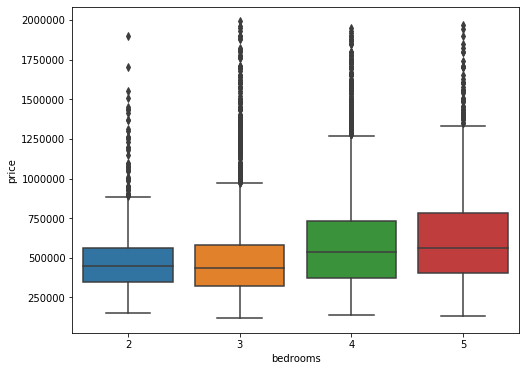

In [826]:
coefficients

plt.figure(figsize=(8,6))

sns.boxplot(x="bedrooms", y="price", data=kc2)


In [827]:
coefficients


[('school_score', 40786.846935656016),
 ('grade', 76076.3177763561),
 ('sqft_living', 123.65113481415908),
 ('nearest_water', -9717.855739475928),
 ('view_4.0', 371041.1578805984),
 ('view_3.0', 190925.99294702732),
 ('view_2.0', 118068.57211440377),
 ('view_1.0', 112610.74530662863)]